In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def extraer_datos(data):
    # Abrir el archivo de texto
    with open(data, "r") as f:
        # Saltar las tres primeras líneas
        next(f)
        next(f)
        next(f)
        
        # Leer todas las líneas restantes
        all_data = f.readlines()   
    
    # Procesar cada línea, dividiendo por tabulaciones
    all_data = [line.strip().split('\t') for line in all_data]
    
    # Extraer la primera columna (muestra)
    sample = [int(row[0]) for row in all_data]  # Primera columna

    # Crear una secuencia de números para la muestra (opcional, según tu lógica)
    sample = np.arange(0, len(sample))  # Reemplaza los valores por una secuencia 0, 1, 2, ..., n
    
    # Extraer la sexta columna (amplitud)
    amplitude = [int(row[5]) for row in all_data]  # Sexta columna (índice 5)
    amplitude = np.array(amplitude)
    return sample, amplitude  # Devolver los valores de la muestra y amplitud

def calcular_SNR(original_signal, filtered_signal):
    # Calcular la potencia de la señal en crudo
    signal_power = np.mean(original_signal ** 2)
    
    # Calcular el ruido (diferencia entre señal original y señal filtrada)
    noise = original_signal - filtered_signal
    noise_power = np.mean(noise ** 2)
    
    # Calcular el SNR
    snr = signal_power / noise_power
    snr = 10 * np.log10(snr)
    return snr

def graficar_barras(valores, etiquetas, xlabel='', ylabel='', titulo=''):
    plt.figure(figsize=(7, 4))

    # Crear el gráfico de barras
    plt.bar(etiquetas, valores, color='blue')

    # Etiquetas de los ejes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Título del gráfico
    plt.title(titulo)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

def grafica(sample, amplitude, filtered_signal):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(sample/1000, amplitude)
    plt.title('Señal  de ECG en crudo: Estado post-ejercicio')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(sample/1000, filtered_signal)
    plt.title('Señal filtrada via Wavelet')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.grid(True)
   
    plt.tight_layout()
    plt.show()

In [24]:
# Mean Absolute Value (MAV)
def mean_absolute_value(sig):
    return np.mean(np.abs(sig))

# Root Mean Square (RMS)
def root_mean_square(sig):
    SSI = np.sum(sig**2)
    return np.sqrt(SSI / len(sig))

# Waveform Length (WL)
def waveform_length(sig):
    WL = 0
    for i in range(1, len(sig)-1):
        s = np.abs(sig[i+1] - sig[i])
        WL += s
    return WL

# Willison Amplitude (WAMP)
def willison_amplitude(sig, th=2.5):
    WAMP = 0
    for i in range(0, len(sig)-1):
        if np.abs(sig[i] - sig[i+1]) >= th:
            f = 1
        else:
            f = 0
        WAMP += f
    return WAMP

# Myopulse Percentage Rate (MYOP)
def myopulse_percentage_rate(sig, T=0.35):
    MYOP = 0
    for i in range(len(sig)):
        if np.abs(sig[i]) > T:
            MYOP += 1
    MYOP = MYOP / len(sig)
    return MYOP

# Variance (VAR)
def variance(sig):
    mean_sig = np.mean(sig)
    VAR = np.sum((sig - mean_sig)**2) / (len(sig) - 1)
    return VAR

# Función principal
def extract_features(sig):
    MAV = mean_absolute_value(sig)
    RMS = root_mean_square(sig)
    WL = waveform_length(sig)
    WAMP = willison_amplitude(sig)
    MYOP = myopulse_percentage_rate(sig)
    VAR = variance(sig)

    return [MAV, RMS, WL, WAMP, MYOP, VAR]

In [3]:
def wavelet_denoising(signal, wavelet, level, thresholds):
    # Descomposición de la señal en 'level' niveles usando la wavelet db6
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Aplicación del umbral en cada nivel de detalle
    for i in range(1, len(coeffs)):
        coeffs[i] = soft_threshold(coeffs[i], thresholds[i-1])
    
    # Reconstrucción de la señal después de la umbralización
    reconstructed_signal = pywt.waverec(coeffs, wavelet)
    
    return reconstructed_signal

# Función de umbralización soft
def soft_threshold(coeff, threshold):
    return np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)

def EmgToVoltage(emg_signal, adc_resolution=10, v_ref=3.3, gain=1000, offset=1.65):
    
    # Número máximo que puede representar el ADC
    max_adc_value = 2**adc_resolution - 1
    
    # Conversión de la señal a voltios
    voltage_signal = (np.array(emg_signal) / max_adc_value) * v_ref
    
    # Restar el offset (centrar la señal en 0)
    adjusted_voltage_signal = voltage_signal - offset
    
    # Ajustar la ganancia del sensor EMG
    emg_voltage = adjusted_voltage_signal / gain
    
    return emg_voltage


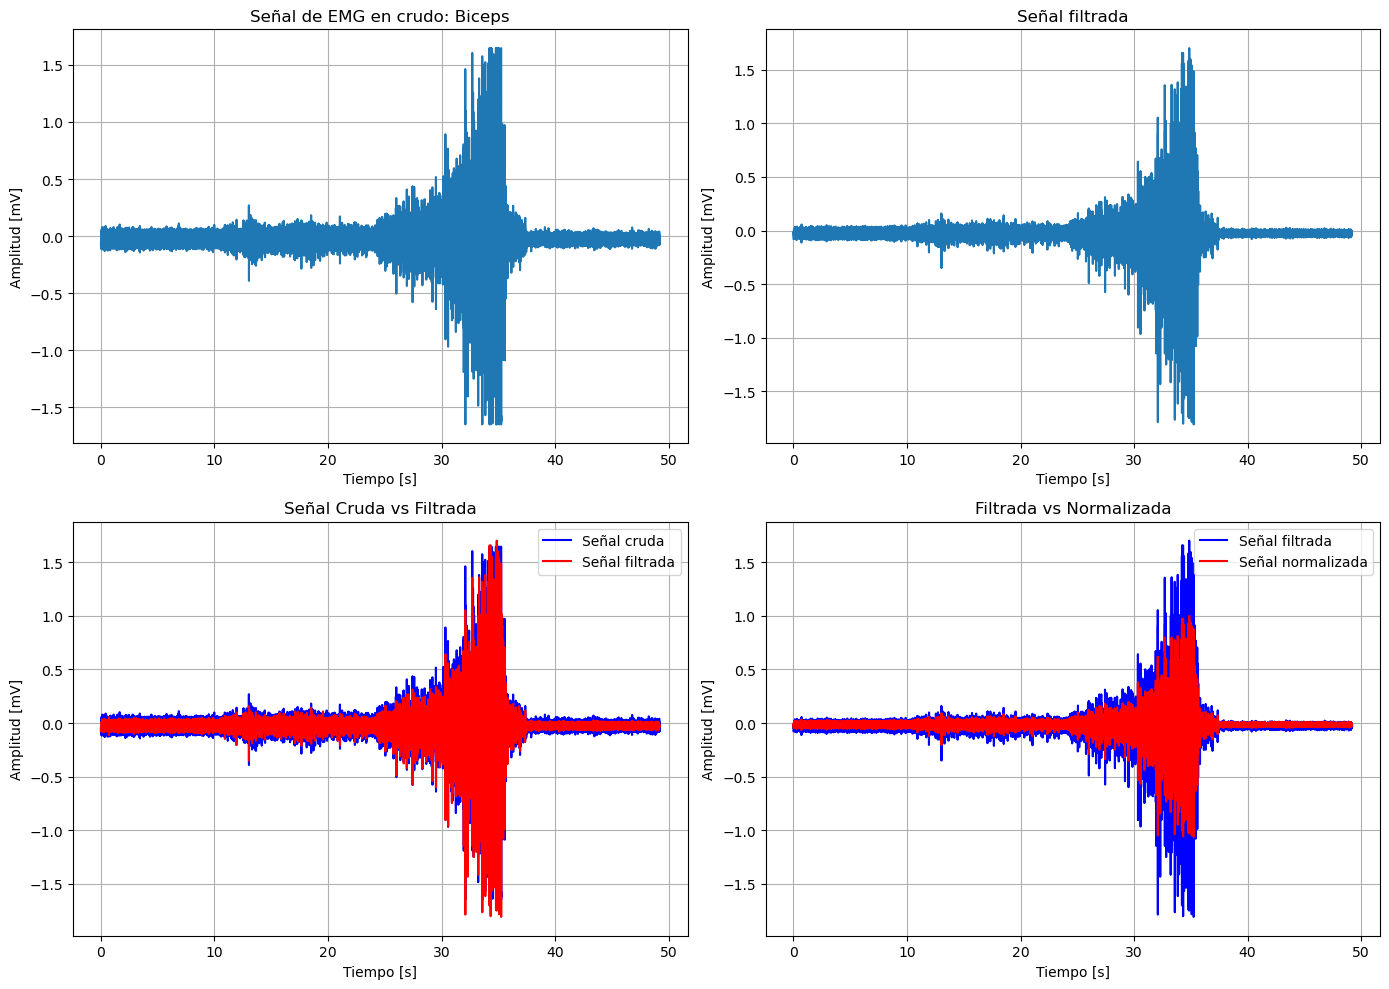

In [33]:
# Cargar los datos y procesarlos
sample, amplitude = extraer_datos("Biceps.txt")
amplitude = EmgToVoltage(amplitude) * 1000

# Filtrado mediante Wavelet
wavelet = 'db6'
level = 4
threshold = [0.022, 0.109, 0.303, 0.742]
filtered_signal = wavelet_denoising(amplitude, wavelet, level, threshold)

# Normalización de la señal filtrada
imvc = np.max(filtered_signal)
normalized_signal = filtered_signal / imvc

# Graficar en un formato de 2x2
plt.figure(figsize=(14, 10))

# Primera gráfica - Señal EMG en crudo
plt.subplot(2, 2, 1)
plt.plot(sample / 1000, amplitude)
plt.title('Señal de EMG en crudo: Biceps')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

# Segunda gráfica - Señal filtrada
plt.subplot(2, 2, 2)
plt.plot(sample / 1000, filtered_signal)
plt.title('Señal filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

# Tercera gráfica - Señal cruda vs filtrada
plt.subplot(2, 2, 3)
plt.plot(sample / 1000, amplitude, label='Señal cruda', color='b')
plt.plot(sample / 1000, filtered_signal, label='Señal filtrada', color='r')
plt.title('Señal Cruda vs Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Cuarta gráfica - Señal filtrada vs normalizada
plt.subplot(2, 2, 4)
plt.plot(sample / 1000, filtered_signal, label='Señal filtrada', color='b')
plt.plot(sample / 1000, normalized_signal, label='Señal normalizada', color='r')
plt.title('Filtrada vs Normalizada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar todas las gráficas
plt.show()



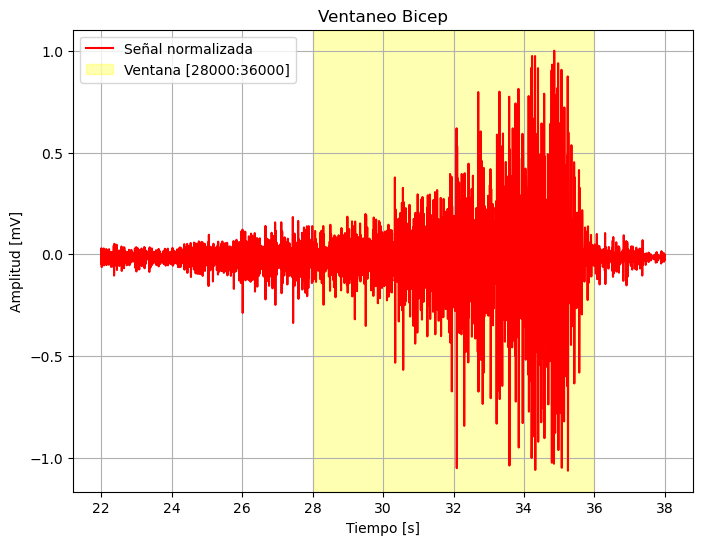

El Mean Absolute Value de la señal: 0.139
El RMS de la señal: 0.215
El Myopulse Percentage Rate de la señal: 0.094
El waveform length de la señal: 382.614
La varianza de la señal: 0.046


In [61]:
plt.figure(figsize=(8, 6))

# Graficar la señal normalizada en el rango [22000:38000]
plt.plot((sample / 1000)[22000:38000], normalized_signal[22000:38000], label='Señal normalizada', color='r')

# Añadir el cuadro para el ventaneo entre 28000 y 35000 (sombrea esa región)
plt.axvspan(28000 / 1000, 36000 / 1000, color='yellow', alpha=0.3, label='Ventana [28000:36000]')

# Configurar el título, etiquetas y leyenda
plt.title('Ventaneo Bicep')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

# Calcular las características de la señal filtrada en la ventana [28000:35000]
MAV, RMS, WL, WAMP, MYOP, VAR = extract_features((filtered_signal/imvc)[28000:36000])

# Imprimir los resultados de las características
print("El Mean Absolute Value de la señal:", round(MAV, 3))
print("El RMS de la señal:", round(RMS, 3))
print("El Myopulse Percentage Rate de la señal:", round(MYOP, 3))
print("El waveform length de la señal:", round(WL, 3))
print("La varianza de la señal:", round(VAR, 3))


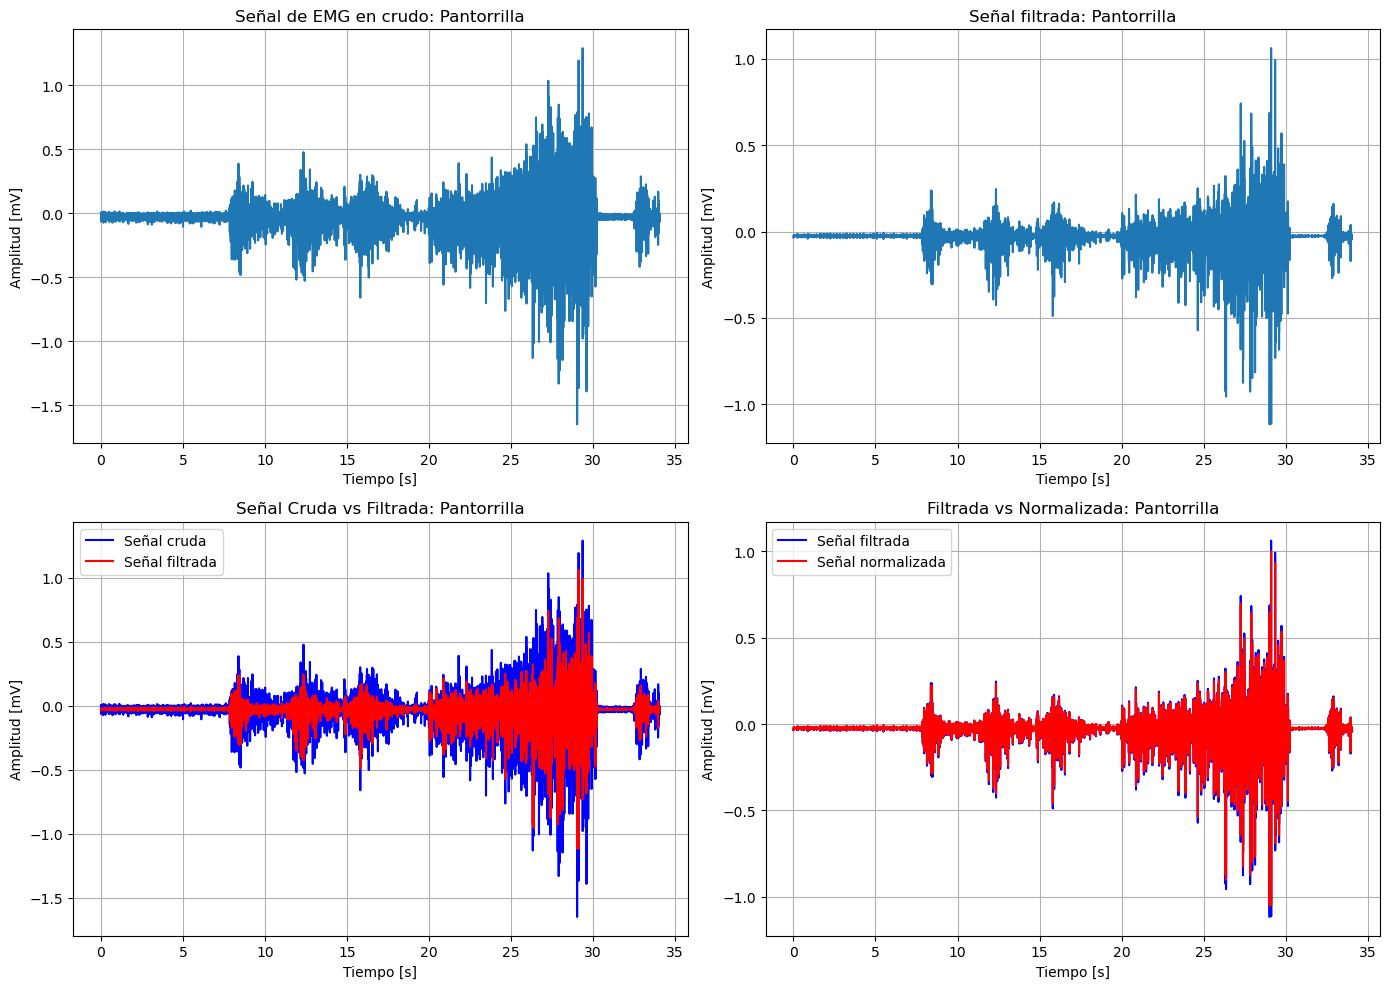

In [40]:
# Cargar los datos y procesarlos para Pantorrilla
sample_pantorrilla, amplitude_pantorrilla = extraer_datos("Pantorrilla.txt")
amplitude_pantorrilla = EmgToVoltage(amplitude_pantorrilla) * 1000

# Filtrado mediante Wavelet para Pantorrilla
wavelet = 'db6'
level = 4
threshold = [0.022, 0.109, 0.303, 0.742]
filtered_signal_pantorrilla = wavelet_denoising(amplitude_pantorrilla, wavelet, level, threshold)

# Normalización de la señal filtrada para Pantorrilla
imvc_pantorrilla = np.max(filtered_signal_pantorrilla)
normalized_signal_pantorrilla = filtered_signal_pantorrilla / imvc_pantorrilla

# Graficar en un formato de 2x2 para Pantorrilla
plt.figure(figsize=(14, 10))

# Primera gráfica - Señal EMG en crudo
plt.subplot(2, 2, 1)
plt.plot(sample_pantorrilla / 1000, amplitude_pantorrilla)
plt.title('Señal de EMG en crudo: Pantorrilla')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

# Segunda gráfica - Señal filtrada
plt.subplot(2, 2, 2)
plt.plot(sample_pantorrilla / 1000, filtered_signal_pantorrilla)
plt.title('Señal filtrada: Pantorrilla')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

# Tercera gráfica - Señal cruda vs filtrada
plt.subplot(2, 2, 3)
plt.plot(sample_pantorrilla / 1000, amplitude_pantorrilla, label='Señal cruda', color='b')
plt.plot(sample_pantorrilla / 1000, filtered_signal_pantorrilla, label='Señal filtrada', color='r')
plt.title('Señal Cruda vs Filtrada: Pantorrilla')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Cuarta gráfica - Señal filtrada vs normalizada
plt.subplot(2, 2, 4)
plt.plot(sample_pantorrilla / 1000, filtered_signal_pantorrilla, label='Señal filtrada', color='b')
plt.plot(sample_pantorrilla / 1000, normalized_signal_pantorrilla, label='Señal normalizada', color='r')
plt.title('Filtrada vs Normalizada: Pantorrilla')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar todas las gráficas
plt.show()



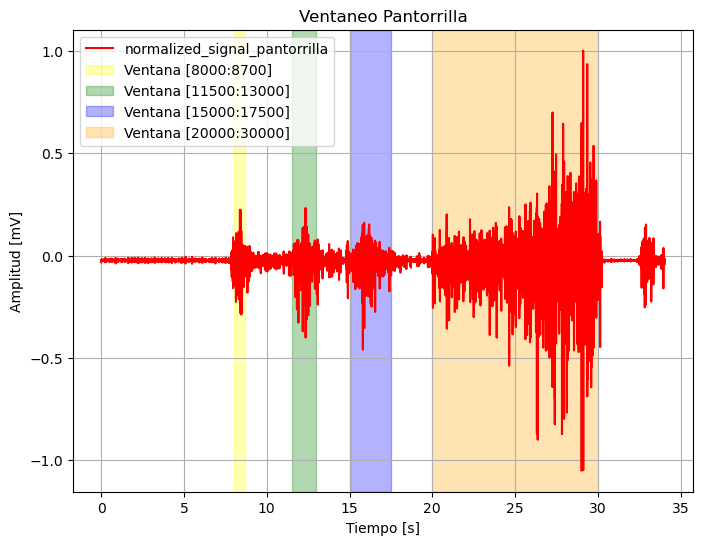

Características para la ventana [8000:8700]:
El Mean Absolute Value de la señal Pantorrilla: 0.053
El RMS de la señal Pantorrilla: 0.075
El Myopulse Percentage Rate de la señal Pantorrilla: 0.0
El waveform length de la señal Pantorrilla: 11.978
La varianza de la señal Pantorrilla: 0.005
--------------------------------------------------
Características para la ventana [11500:13000]:
El Mean Absolute Value de la señal Pantorrilla: 0.044
El RMS de la señal Pantorrilla: 0.066
El Myopulse Percentage Rate de la señal Pantorrilla: 0.002
El waveform length de la señal Pantorrilla: 22.751
La varianza de la señal Pantorrilla: 0.004
--------------------------------------------------
Características para la ventana [15000:17500]:
El Mean Absolute Value de la señal Pantorrilla: 0.04
El RMS de la señal Pantorrilla: 0.057
El Myopulse Percentage Rate de la señal Pantorrilla: 0.002
El waveform length de la señal Pantorrilla: 30.019
La varianza de la señal Pantorrilla: 0.003
---------------------------

In [76]:


plt.figure(figsize=(8, 6))

# Graficar la señal normalizada completa
plt.plot(np.arange(len(normalized_signal_pantorrilla)) / 1000, normalized_signal_pantorrilla, label='normalized_signal_pantorrilla', color='r')

# Añadir los cuadros para el ventaneo
plt.axvspan(8000 / 1000, 8700 / 1000, color='yellow', alpha=0.3, label='Ventana [8000:8700]')
plt.axvspan(11500 / 1000, 13000 / 1000, color='green', alpha=0.3, label='Ventana [11500:13000]')
plt.axvspan(15000 / 1000, 17500 / 1000, color='blue', alpha=0.3, label='Ventana [15000:17500]')
plt.axvspan(20000 / 1000, 30000 / 1000, color='orange', alpha=0.3, label='Ventana [20000:30000]')

# Configurar el título, etiquetas y leyenda
plt.title('Ventaneo Pantorrilla')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

# Definir las ventanas
ventanas = [(8000, 8700), (11500, 13000), (15000, 17500), (20000, 30000)]

# Extraer características para cada ventana
for i, (start, end) in enumerate(ventanas):
    MAV, RMS, WL, WAMP, MYOP, VAR = extract_features(normalized_signal_pantorrilla[start:end])

    # Imprimir las características para cada ventana
    print(f"Características para la ventana [{start}:{end}]:")
    print("El Mean Absolute Value de la señal Pantorrilla:", round(MAV, 3))
    print("El RMS de la señal Pantorrilla:", round(RMS, 3))
    print("El Myopulse Percentage Rate de la señal Pantorrilla:", round(MYOP, 3))
    print("El waveform length de la señal Pantorrilla:", round(WL, 3))
    print("La varianza de la señal Pantorrilla:", round(VAR, 3))
    print("-" * 50)  # Separador entre ventanas


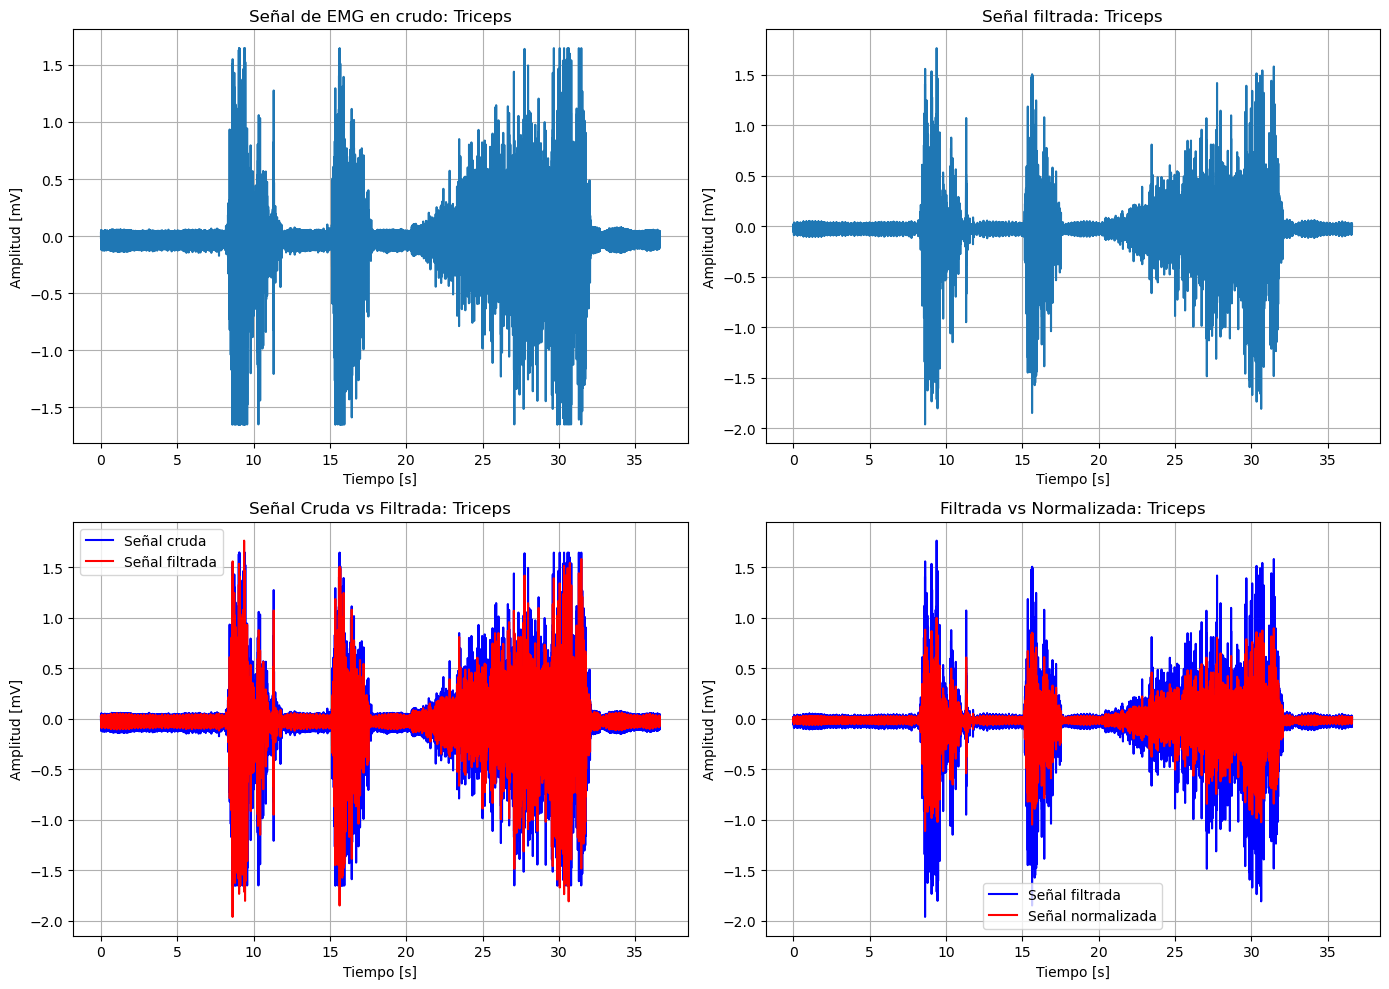

In [44]:
# Cargar los datos y procesarlos para Triceps
sample_triceps, amplitude_triceps = extraer_datos("Triceps.txt")
amplitude_triceps = EmgToVoltage(amplitude_triceps) * 1000

# Filtrado mediante Wavelet para Triceps
wavelet = 'db6'
level = 4
threshold = [0.022, 0.109, 0.303, 0.742]
filtered_signal_triceps = wavelet_denoising(amplitude_triceps, wavelet, level, threshold)

# Normalización de la señal filtrada para Triceps
imvc_triceps = np.max(filtered_signal_triceps)
normalized_signal_triceps = filtered_signal_triceps / imvc_triceps

# Graficar en un formato de 2x2 para Triceps
plt.figure(figsize=(14, 10))

# Primera gráfica - Señal EMG en crudo
plt.subplot(2, 2, 1)
plt.plot(sample_triceps / 1000, amplitude_triceps)
plt.title('Señal de EMG en crudo: Triceps')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

# Segunda gráfica - Señal filtrada
plt.subplot(2, 2, 2)
plt.plot(sample_triceps / 1000, filtered_signal_triceps)
plt.title('Señal filtrada: Triceps')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.grid(True)

# Tercera gráfica - Señal cruda vs filtrada
plt.subplot(2, 2, 3)
plt.plot(sample_triceps / 1000, amplitude_triceps, label='Señal cruda', color='b')
plt.plot(sample_triceps / 1000, filtered_signal_triceps, label='Señal filtrada', color='r')
plt.title('Señal Cruda vs Filtrada: Triceps')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Cuarta gráfica - Señal filtrada vs normalizada
plt.subplot(2, 2, 4)
plt.plot(sample_triceps / 1000, filtered_signal_triceps, label='Señal filtrada', color='b')
plt.plot(sample_triceps / 1000, normalized_signal_triceps, label='Señal normalizada', color='r')
plt.title('Filtrada vs Normalizada: Triceps')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar todas las gráficas
plt.show()


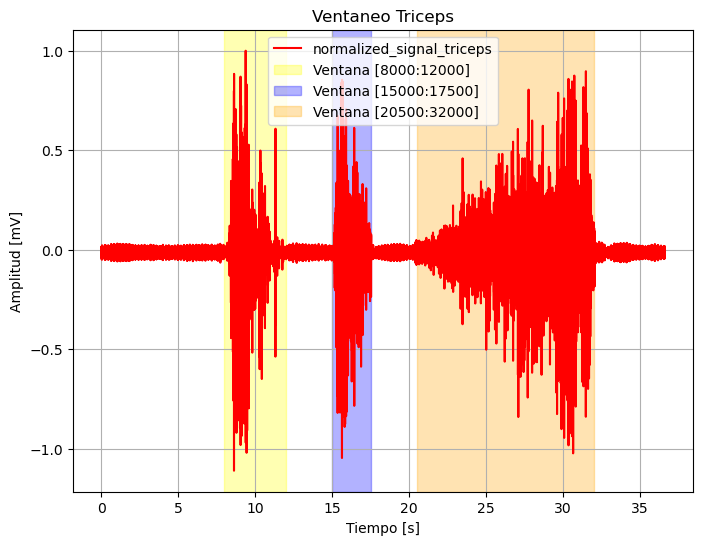

Características para la ventana [8000:12000]:
El Mean Absolute Value de la señal Triceps: 0.103
El RMS de la señal Triceps: 0.183
El Myopulse Percentage Rate de la señal Triceps: 0.071
El waveform length de la señal Triceps: 261.391
La varianza de la señal Triceps: 0.033
--------------------------------------------------
Características para la ventana [15000:17500]:
El Mean Absolute Value de la señal Triceps: 0.118
El RMS de la señal Triceps: 0.183
El Myopulse Percentage Rate de la señal Triceps: 0.07
El waveform length de la señal Triceps: 200.384
La varianza de la señal Triceps: 0.033
--------------------------------------------------
Características para la ventana [20500:32000]:
El Mean Absolute Value de la señal Triceps: 0.097
El RMS de la señal Triceps: 0.147
El Myopulse Percentage Rate de la señal Triceps: 0.037
El waveform length de la señal Triceps: 584.956
La varianza de la señal Triceps: 0.021
--------------------------------------------------


In [82]:
plt.figure(figsize=(8, 6))

# Graficar la señal normalizada completa
plt.plot(np.arange(len(normalized_signal_triceps)) / 1000, normalized_signal_triceps, label='normalized_signal_triceps', color='r')

# Añadir los cuadros para el ventaneo
plt.axvspan(8000 / 1000, 12000 / 1000, color='yellow', alpha=0.3, label='Ventana [8000:12000]')
plt.axvspan(15000 / 1000, 17500 / 1000, color='blue', alpha=0.3, label='Ventana [15000:17500]')
plt.axvspan(20500 / 1000, 32000 / 1000, color='orange', alpha=0.3, label='Ventana [20500:32000]')

# Configurar el título, etiquetas y leyenda
plt.title('Ventaneo Triceps')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

# Definir las ventanas de interés
ventanas_triceps = [(8000, 12000), (15000, 17500), (20500, 32000)]

# Extraer características para cada ventana
for i, (start, end) in enumerate(ventanas_triceps):
    MAV, RMS, WL, WAMP, MYOP, VAR = extract_features(normalized_signal_triceps[start:end])
    
    # Imprimir las características para cada ventana
    print(f"Características para la ventana [{start}:{end}]:")
    print("El Mean Absolute Value de la señal Triceps:", round(MAV, 3))
    print("El RMS de la señal Triceps:", round(RMS, 3))
    print("El Myopulse Percentage Rate de la señal Triceps:", round(MYOP, 3))
    print("El waveform length de la señal Triceps:", round(WL, 3))
    print("La varianza de la señal Triceps:", round(VAR, 3))
    print("-" * 50)  # Separador entre ventanas

